In [1]:
import numpy as np
from scipy import stats
from numpy import nan
import pandas as pd
import s3fs
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_precision_recall_curve, plot_roc_curve
import statistics
from matplotlib import pyplot as plt
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
import pickle


In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [4]:
conn = sf_connection()

### Let's read in the features we created

In [5]:
feature_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/score/yes_ecomm.parquet'

In [6]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

### Now we read in the label data

In [7]:
label_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/discount_lables.csv'

In [8]:
label_table = pd.read_csv(label_path, header=0)

In [9]:
len(feature_table.drop_duplicates('INDV_ID')), len(label_table.drop_duplicates('INDV_ID'))

(22529095, 22327757)

### Now we inner join on INDV_ID

In [10]:
combined_table = pd.merge(feature_table, label_table, on='INDV_ID', how='inner')

In [11]:
len(combined_table)

22325083

In [12]:
combined_table.drop_duplicates('INDV_ID', inplace=True)

In [13]:
len(combined_table)

22325083

## We now create three more features

In [14]:
combined_table['ecomm_frac'] = combined_table['numEcom']/combined_table['numPurchase']

In [15]:
combined_table['is_sp'] = combined_table['LOYALTY_NUMBER'].apply(lambda x: 1 if x > 0 else 0)

In [16]:
combined_table['is_ecomm'] = combined_table['ecomm_frac'].apply(lambda x: 1 if x > 0.0 else 0)

### Only model customers with ecommerce engagement  - we will predict customers without eComm engatement as 'not discount sensitive'

In [17]:
ecomm_table = combined_table[combined_table.is_ecomm==1].copy()

In [18]:
no_ecomm_table = combined_table[combined_table.is_ecomm==0].copy()

In [19]:
len(no_ecomm_table)

18835517

### Now we join with dim_store to get the market type

In [20]:
store_query = """select STORE_NUMBER, MARKET_CLASS_CODE from PEDW.LOCATION.DIM_STORE_V"""

In [21]:
store_xref = pd.read_sql(store_query, conn)

In [22]:
len(store_xref)

7620

In [23]:
store_xref = store_xref[store_xref.MARKET_CLASS_CODE != 'UNKNOWN'].copy()

In [24]:
len(store_xref)

6009

In [25]:
store_xref['MARKET_CLASS_CODE'] = store_xref['MARKET_CLASS_CODE'].apply(lambda x: int(x))

In [26]:
store_xref.dtypes

STORE_NUMBER         int64
MARKET_CLASS_CODE    int64
dtype: object

In [27]:
store_xref.rename(columns={'STORE_NUMBER': 'FULLFILLMENT_STORE_NUMBER'}, inplace=True)

### Now let's look at distances to AAP and competitor stores

In [30]:
aap_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V 
    where (INDV_ID, STORE_NUMBER, LOAD_TS) in (select INDV_ID, STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V
                                                group by INDV_ID, STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [31]:
aap_dist = pd.read_sql(aap_query, conn)

In [32]:
len(aap_dist)

119665354

In [33]:
comp_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
    where (INDV_ID, CMP_STORE_NUMBER, LOAD_TS) in (select INDV_ID, CMP_STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
                                                group by INDV_ID, CMP_STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [34]:
comp_dist = pd.read_sql(comp_query, conn)

In [35]:
len(comp_dist)

121034820

In [36]:
aap_dist = aap_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'AAP_DIST'})

In [37]:
comp_dist = comp_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'CMP_DIST'})

In [38]:
len(aap_dist), len(aap_dist.drop_duplicates('INDV_ID'))

(119665354, 119665354)

In [39]:
len(comp_dist), len(comp_dist.drop_duplicates('INDV_ID'))

(121034820, 121034820)

### Now let's get the customer lifetime (tenure)

In [40]:
tenure_query = """
    select 
        INDV_ID, 
        datediff(day, INDV_FIRST_TRANSACTION_DATE, '2021-03-01') as TENURE
    from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
    where (INDV_ID,LOAD_TS) in
        (select INDV_ID, max(LOAD_TS) from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
        group by INDV_ID)
        """

In [41]:
tenure = pd.read_sql(tenure_query, conn)

In [42]:
tenure.dtypes

INDV_ID    int64
TENURE     int64
dtype: object

In [43]:
tenure.head()

INDV_ID  TENURE
0  139569689    1316
1  196152655    2497
2  468967074    2196
3  572725517    1487
4  605721347     782

In [44]:
features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'TOTAL',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [45]:
label = ['3quarter']

In [46]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

### Now we process the no_ecomm custmers

In [47]:
len(no_ecomm_table)

18835517

In [48]:
list(no_ecomm_table.columns)

['INDV_ID',
 'fyGross',
 '2hGross',
 '4qGross',
 'fyNet',
 '2hNet',
 '4qNet',
 'numEcom',
 'numPurchase',
 'Recency',
 'daysSinceLastPurchase',
 'isEmployee',
 'numReturn',
 'numCoupon',
 'LOYALTY_NUMBER',
 'meanPurchaseTransaction',
 'FULLFILLMENT_STORE_NUMBER',
 'pop_est_cy',
 'pop_density_cy',
 'pct_white',
 'age',
 'pct_college',
 'pct_blue_collar',
 'median_household_income',
 'establishments',
 'IGNITIONEMISSIONFUELSYSTEMS',
 'ADVANCECARESERVICES',
 'AIRFILTERS',
 'LIGHTING',
 'HDHVAC&HYDRAULICS',
 'COMMERCIALHANDSPECIALTYTOOLS',
 'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
 'WINTER&SUMMERSEASONAL',
 'MOTOROIL',
 'HORNSANDSECURITY',
 'COOLINGSYSTEMRADIATORS',
 'GREASE&GEAR',
 'OILFILTERS',
 'APPEARANCECHEMICALS',
 'HDFILTERS',
 'INTERIORACCESSORIES',
 'HDWHEELEND',
 'BRAKESHARDWARE',
 'OIL&GASACCESSORIES',
 'AIRTOOLS&ACCESSORIES',
 'PERFORMANCE&FUNCTIONALCHEMICALS',
 'STORESUPPLIES&FIXTURES',
 'BRAKESHYDRAULICS',
 'HDOTHER',
 'OTHERCORES',
 'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
 'RE

### Now we join our new feature dataframes to the no_ecomm table and fill nas

#### First the market code

In [49]:
no_ecomm_table = pd.merge(no_ecomm_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [50]:
no_ecomm_table.isnull().sum()

INDV_ID                                        0
fyGross                                        0
2hGross                                        0
4qGross                                        0
fyNet                                          0
2hNet                                          0
4qNet                                          0
numEcom                                        0
numPurchase                                    0
Recency                                        0
daysSinceLastPurchase                          0
isEmployee                                     0
numReturn                                      0
numCoupon                                      0
LOYALTY_NUMBER                                 0
meanPurchaseTransaction                        0
FULLFILLMENT_STORE_NUMBER                      0
pop_est_cy                                     0
pop_density_cy                                 0
pct_white                                      0
age                 

#### Fill nulls with 0

In [51]:
no_ecomm_table.fillna(0, inplace=True)

#### Now aap store distances

In [52]:
no_ecomm_table = pd.merge(no_ecomm_table, aap_dist, how='left', on='INDV_ID')

In [53]:
no_ecomm_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [54]:
no_ecomm_table['AAP_DIST'] = no_ecomm_table['AAP_DIST'].fillna(no_ecomm_table['AAP_DIST'].mean())

#### Now competitor store distances

In [55]:
no_ecomm_table = pd.merge(no_ecomm_table, comp_dist, how='left', on='INDV_ID')

In [56]:
no_ecomm_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [57]:
no_ecomm_table['CMP_DIST'] = no_ecomm_table['CMP_DIST'].fillna(no_ecomm_table['CMP_DIST'].mean())

In [58]:
no_ecomm_table['aap_closer_by'] = no_ecomm_table['CMP_DIST'] - no_ecomm_table['AAP_DIST']

In [59]:
no_ecomm_table['comp_dist_ratio'] = no_ecomm_table['CMP_DIST']/no_ecomm_table['AAP_DIST']

### Now let's get the customer lifetime (tenure)

In [60]:
no_ecomm_table = pd.merge(no_ecomm_table, tenure, how='left', on='INDV_ID')

In [61]:
no_ecomm_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [62]:
no_ecomm_table.loc[(no_ecomm_table.TENURE < 1), 'TENURE'] = 1

In [63]:
label = ['3quarter']

In [64]:
no_ecomm_table = no_ecomm_table[features + label]

### Now we evaluate the class balance

In [65]:
summary = no_ecomm_table.groupby(label)['TENURE'].count().reset_index()

In [66]:
summary['FRACTION'] = summary['TENURE']/summary['TENURE'].sum()

In [67]:
summary

3quarter    TENURE             FRACTION
0         0  17720955                0.941
1         1   1114564                0.059

### We one-hot encode market class

In [68]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto', dtype=np.int, handle_unknown='ignore')

In [69]:
market_class_feature = onehot_encoder.fit_transform(no_ecomm_table[['MARKET_CLASS_CODE']])


In [70]:
market_class_feature.shape

(18835519, 8)

In [71]:
market_categories = [cat for cat in onehot_encoder.categories_[0]]

In [72]:
market_categories

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [73]:
market_categories_dict = {0: 'zero', 
                             1: 'one',
                             2: 'two',
                             3: 'three',
                             4: 'four',
                             5: 'five',
                             6: 'six',
                             7: 'seven'}

In [74]:
market_categories = list(map(market_categories_dict.get, market_categories))

In [75]:
market_class_dataframe = pd.DataFrame(market_class_feature)
market_class_dataframe.columns = market_categories

In [76]:
market_class_dataframe.head()

zero  one  two  three  four  five  six  seven
0     0    0    0      0     0     0    1      0
1     0    0    0      0     0     0    1      0
2     0    0    0      0     0     0    1      0
3     0    0    0      0     0     1    0      0
4     0    0    0      0     0     0    1      0

In [77]:
no_ecomm_table.reset_index(drop=True, inplace=True)

In [78]:
len(no_ecomm_table), len(market_class_dataframe)

(18835519, 18835519)

In [79]:
no_ecomm_table = pd.merge(no_ecomm_table, market_class_dataframe, left_index=True, right_index=True)

In [80]:
no_ecomm_table[market_categories + ['MARKET_CLASS_CODE']].head(20)

zero  one  two  three  four  five  six  seven    MARKET_CLASS_CODE
0      0    0    0      0     0     0    1      0                6.000
1      0    0    0      0     0     0    1      0                6.000
2      0    0    0      0     0     0    1      0                6.000
3      0    0    0      0     0     1    0      0                5.000
4      0    0    0      0     0     0    1      0                6.000
5      0    0    0      0     0     0    1      0                6.000
6      0    0    0      0     0     0    1      0                6.000
7      0    0    0      0     0     0    1      0                6.000
8      0    0    0      0     0     0    1      0                6.000
9      0    0    0      0     0     1    0      0                5.000
10     0    0    0      0     0     0    1      0                6.000
11     0    0    0      0     0     0    1      0                6.000
12     0    0    0      0     0     0    1      0                6.000
13     0    0    0      0     0     0    1      0                6.000
14     0    0    0      0     0     0    1      0                6.000
15     0    0    0      0     0     0    0      1                7.000
16     0    0    0      0     0     0    1      0                6.000
17     0    0    0      0     1     0    0      0                4.000
18     0    0    0      0     0     0    1      0                6.000
19     0    0    0      0     0     1    0      0                5.000

In [81]:
no_ecomm_table.drop(columns={'MARKET_CLASS_CODE'}, inplace=True)

In [82]:
features = [feature for feature in features if feature != 'MARKET_CLASS_CODE']

### Now we split the no_ecomm table into train and test

In [83]:
X_train, X_test, y_train, y_test = train_test_split(no_ecomm_table[features], no_ecomm_table[label], 
                                                    test_size=0.5, random_state=1, stratify=no_ecomm_table[label])

### We lock up the test (holdout) set in a vault, and split the training set into use and validate.  We will use the validation set for tuning

In [84]:
X_use, X_validate, y_use, y_validate = train_test_split(X_train, y_train, 
                                                    test_size=0.5, random_state=1, stratify=y_train)

### Now we're going to increase the number of epochs to 500 --- this will hopefully result in a lower learning rate.  

In [88]:
def objective(space):    
        xg_class = xgb.XGBClassifier(n_estimators=500, 
                                  max_depth=space['max_depth'], gamma=space['gamma'],
                                  reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'],
                                  min_child_weight=space['min_child_weight'],
                                  colsample_bytree=space['colsample_bytree'],
                                  subsample=space['subsample'],
                                  learning_rate=space['learning_rate'],
                                  seed=6,
                                  scale_pos_weight=17720955/1114564)    
        eval_set = [(X_use, y_use), (X_validate, y_validate)]
        xg_class.fit(X_use, y_use, eval_set=eval_set, eval_metric='map',
                early_stopping_rounds=10, verbose=False)
        results = xg_class.evals_result()
        validation_map_lost = 1.0 - results['validation_1']['map'][-1]
        return {'loss': validation_map_lost, 'status': STATUS_OK}

In [89]:
 space={'max_depth': hp.choice("max_depth", np.arange(2, 16, dtype=int)),
           'gamma': hp.uniform('gamma',0.0, 5.0),
           'reg_alpha': hp.uniform('reg_alpha', 0, 1000.0),
           'reg_lambda': hp.uniform('reg_lambda',0, 1000),
           'min_child_weight': hp.uniform('min_child_weight', 0, 120),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.95),
           'learning_rate': hp.uniform('learning_rate', 0.1, 0.7),
           'subsample': hp.uniform('subsample', 0.5, 0.95)
          }

In [90]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        return_argmin=False,
                        rstate= np.random.RandomState(2))

100%|██████████| 100/100 [41:58:12<00:00, 1510.93s/trial, best loss: 0.495482]  


In [91]:
best_hyperparams

{'colsample_bytree': 0.8997893858865803,
 'gamma': 2.3462546516514164,
 'learning_rate': 0.27761021578751666,
 'max_depth': 11,
 'min_child_weight': 70.65330585500513,
 'reg_alpha': 373.34772928790585,
 'reg_lambda': 232.05908798490452,
 'subsample': 0.9219610424898453}

In [97]:
xg_class = xgb.XGBClassifier(**best_hyperparams, n_jobs=90, n_estimators=500,  scale_pos_weight=17720955/1114564)

In [98]:
xg_class

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8997893858865803,
              gamma=2.3462546516514164, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.27761021578751666,
              max_delta_step=None, max_depth=11,
              min_child_weight=70.65330585500513, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=90,
              num_parallel_tree=None, random_state=None,
              reg_alpha=373.34772928790585, reg_lambda=232.05908798490452,
              scale_pos_weight=15.899450368036291, subsample=0.9219610424898453,
              tree_method=None, validate_parameters=None, verbosity=None)

In [100]:
eval_set = [(X_train, y_train)] 
_ = xg_class.fit(X_train, y_train, eval_set=eval_set, eval_metric='map',
            early_stopping_rounds=10, verbose=True)

[0]	validation_0-map:0.23446
[1]	validation_0-map:0.25670
[2]	validation_0-map:0.26621
[3]	validation_0-map:0.26931
[4]	validation_0-map:0.28120
[5]	validation_0-map:0.29251
[6]	validation_0-map:0.29929
[7]	validation_0-map:0.31083
[8]	validation_0-map:0.31300
[9]	validation_0-map:0.31705
[10]	validation_0-map:0.31851
[11]	validation_0-map:0.31996
[12]	validation_0-map:0.32304
[13]	validation_0-map:0.32500
[14]	validation_0-map:0.32666
[15]	validation_0-map:0.32994
[16]	validation_0-map:0.33558
[17]	validation_0-map:0.33796
[18]	validation_0-map:0.34235
[19]	validation_0-map:0.34417
[20]	validation_0-map:0.34547
[21]	validation_0-map:0.34723
[22]	validation_0-map:0.35158
[23]	validation_0-map:0.35193
[24]	validation_0-map:0.35363
[25]	validation_0-map:0.35511
[26]	validation_0-map:0.36658
[27]	validation_0-map:0.36699
[28]	validation_0-map:0.37250
[29]	validation_0-map:0.37287
[30]	validation_0-map:0.37320
[31]	validation_0-map:0.37381
[32]	validation_0-map:0.37816
[33]	validation_0-ma

In [101]:
test_pred = xg_class.predict(X_test)

In [102]:
test_score = xg_class.predict_proba(X_test)

In [103]:
test_score_unpacked = [score[1] for score in test_score]

In [104]:
confusion_matrix(y_test, test_pred)

array([[7463119, 1397359],
       [ 135987,  421295]])

In [105]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91   8860478
           1       0.23      0.76      0.35    557282

    accuracy                           0.84   9417760
   macro avg       0.61      0.80      0.63   9417760
weighted avg       0.94      0.84      0.87   9417760



In [106]:
roc_auc_score(y_test,test_score_unpacked)

0.882845558738141

In [107]:
average_precision_score(y_test, test_score_unpacked, pos_label=1)

0.5299749740867609

Text(0.5, 1.0, 'Precision/Recall Curve, Positive Class is "discount sensitive"')

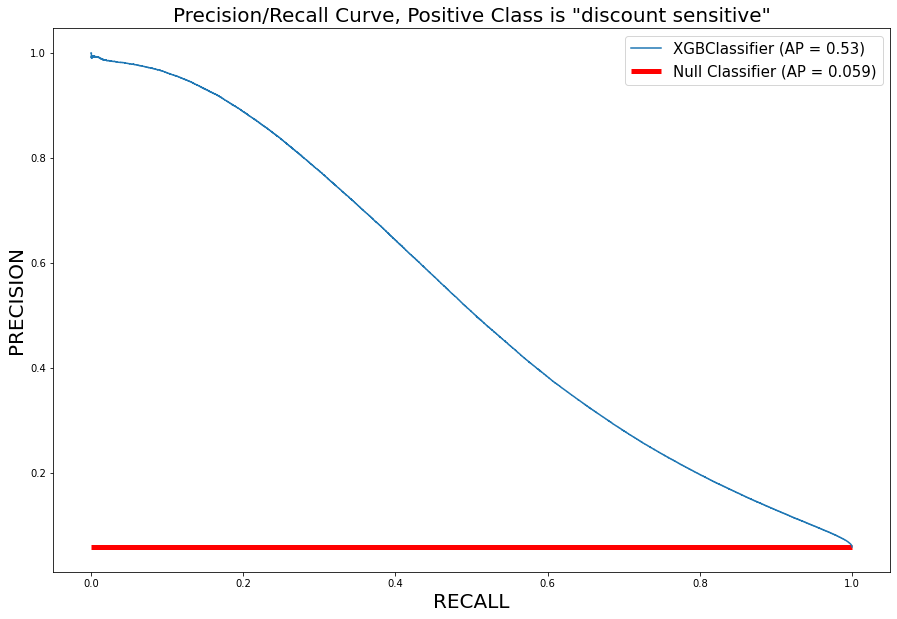

In [108]:
fig = plot_precision_recall_curve(xg_class, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
plt.hlines(0.059, 0.0, 1.0, colors='red', label="Null Classifier (AP = 0.059)", linewidth=5)
plt.xlabel('RECALL', size='20')
plt.ylabel('PRECISION', size='20')
plt.legend(loc='upper right', fontsize=15)
plt.title('Precision/Recall Curve, Positive Class is "discount sensitive"', size='20')

Text(0.5, 1.0, 'ROC Curve, Positive Class is "discount sensitive"')

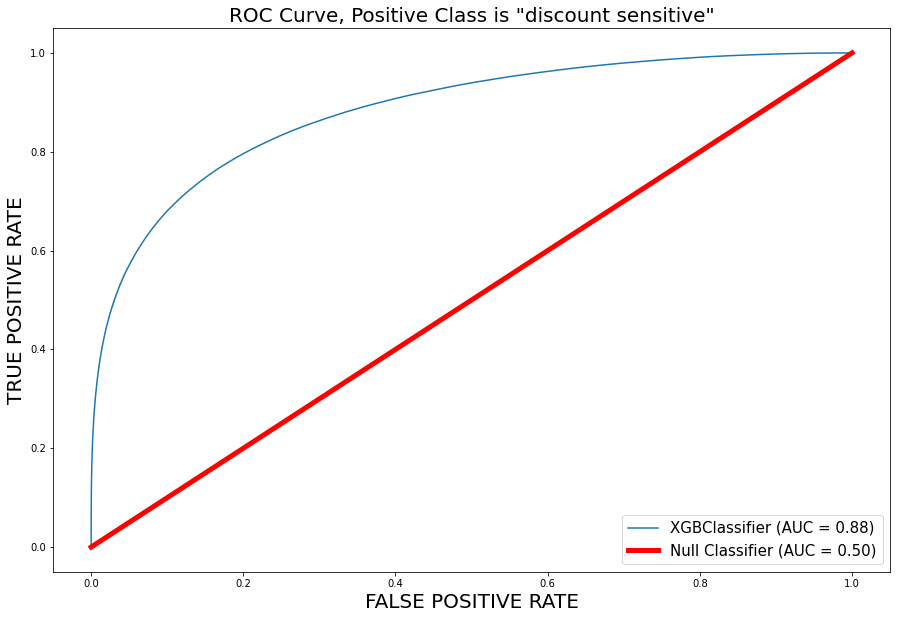

In [109]:
fig = plot_roc_curve(xg_class, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
fig.ax_.plot([0, 1], [0, 1], 'red', linewidth=5, label="Null Classifier (AUC = 0.50)")
plt.xlabel('FALSE POSITIVE RATE', size='20')
plt.ylabel('TRUE POSITIVE RATE', size='20')
plt.legend(loc='lower right', fontsize=15)
plt.title('ROC Curve, Positive Class is "discount sensitive"', size='20')